# All Sites Random Forest: Unloading Paper
## Notebook #1 
* first notebook to perform random forest analysis for the unloading paper

created by Cassie Lumbrazo\
date: Sept 2023\
python environment: **raster**, using raster for now


In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr

import copy 
import pickle

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import pydotplus 
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

### Load the merged and subsampled data into a pkl (saved in Notebook 4 first)

In [81]:
df_unload = pd.read_csv("allsites_snowunload.csv")
df_unload.head()

datetime  shortwave  longwave  windspeed      RH   temp    A   
0  2016-10-06 06:00:00       4.93   297.470      1.180  96.650 -3.495  1.0  \
1  2016-10-06 07:00:00      29.43   298.655      1.735  93.195 -3.325  1.0   
2  2016-10-06 08:00:00     124.50   309.965      2.080  83.190 -2.430  1.0   
3  2016-10-06 09:00:00     102.04   306.465      2.745  90.135 -3.250  1.0   
4  2016-10-06 10:00:00     614.38   240.145      4.595  80.390 -3.350  1.0   

     B   CD    E  Type Class Snow      Sunlit Classification  Typesymbol   
0  0.0  1.0  0.0   NaN   NaN  NaN  Not Sunlit   Snow Staying       128.0  \
1  0.0  1.0  0.0   NaN   NaN  NaN  Not Sunlit   Snow Staying       128.0   
2  0.0  1.0  0.0   NaN   NaN  NaN  Not Sunlit   Snow Staying       128.0   
3  0.0  1.0  0.0   NaN   NaN  NaN  Not Sunlit   Snow Staying       128.0   
4  1.0  1.0  0.0   NaN   NaN  NaN  Not Sunlit   Snow Staying       128.0   

   Snowsymbol   site  pressure  snowdepth  
0       128.0  niwot       NaN        NaN  
1       128.0  niwot       NaN        NaN  
2       128.0  niwot       NaN        NaN  
3       128.0  niwot       NaN        NaN  
4       128.0  niwot       NaN        NaN

In [82]:
df_unload.Classification.value_counts()

Classification
Snow Staying      1288
Snow Unloading     446
Name: count, dtype: int64

# Random Forest

### Prepare the dataset for Random Forest

In [83]:
# cannot have any nans for random forest... so let's start by deleting columns we do not need 
df_int = df_unload.copy(deep=True)
df_int = df_int.drop(columns=['datetime', 'longwave', 'RH', 'pressure', 'snowdepth']) # the major ones
df_int.head()

shortwave  windspeed   temp    A    B   CD    E  Type Class Snow   
0       4.93      1.180 -3.495  1.0  0.0  1.0  0.0   NaN   NaN  NaN  \
1      29.43      1.735 -3.325  1.0  0.0  1.0  0.0   NaN   NaN  NaN   
2     124.50      2.080 -2.430  1.0  0.0  1.0  0.0   NaN   NaN  NaN   
3     102.04      2.745 -3.250  1.0  0.0  1.0  0.0   NaN   NaN  NaN   
4     614.38      4.595 -3.350  1.0  1.0  1.0  0.0   NaN   NaN  NaN   

       Sunlit Classification  Typesymbol  Snowsymbol   site  
0  Not Sunlit   Snow Staying       128.0       128.0  niwot  
1  Not Sunlit   Snow Staying       128.0       128.0  niwot  
2  Not Sunlit   Snow Staying       128.0       128.0  niwot  
3  Not Sunlit   Snow Staying       128.0       128.0  niwot  
4  Not Sunlit   Snow Staying       128.0       128.0  niwot

In [84]:
# also drop the ones that are not important right now 
df_int = df_int.drop(columns=['A','B','E','Type','Class','Snow', 'Sunlit', 'Typesymbol', 'Snowsymbol'])
df_int.head()

shortwave  windspeed   temp   CD Classification   site
0       4.93      1.180 -3.495  1.0   Snow Staying  niwot
1      29.43      1.735 -3.325  1.0   Snow Staying  niwot
2     124.50      2.080 -2.430  1.0   Snow Staying  niwot
3     102.04      2.745 -3.250  1.0   Snow Staying  niwot
4     614.38      4.595 -3.350  1.0   Snow Staying  niwot

In [85]:
# Saving this simplified dataframe for use later 
df_int_sites = (df_int.copy(deep=True)).dropna()
df_int_sites.head()

shortwave  windspeed   temp   CD Classification   site
0       4.93      1.180 -3.495  1.0   Snow Staying  niwot
1      29.43      1.735 -3.325  1.0   Snow Staying  niwot
2     124.50      2.080 -2.430  1.0   Snow Staying  niwot
3     102.04      2.745 -3.250  1.0   Snow Staying  niwot
4     614.38      4.595 -3.350  1.0   Snow Staying  niwot

In [86]:
len(df_int_sites)

1650

In [87]:
df_int = df_int.drop(columns=['Classification', 'site'])
df_int.head()

shortwave  windspeed   temp   CD
0       4.93      1.180 -3.495  1.0
1      29.43      1.735 -3.325  1.0
2     124.50      2.080 -2.430  1.0
3     102.04      2.745 -3.250  1.0
4     614.38      4.595 -3.350  1.0

In [88]:
# now, drop na from the very simple dataframe
df_int = df_int.dropna()
len(df_int)

1650

In [89]:
df_int['CD'] =        df_int['CD'].astype(int)
df_int['temp'] =      df_int['temp'].astype(int)
df_int['shortwave'] = df_int['shortwave'].astype(int)
df_int['windspeed'] = df_int['windspeed'].astype(int)

df_int.head()

shortwave  windspeed  temp  CD
0          4          1    -3   1
1         29          1    -3   1
2        124          2    -2   1
3        102          2    -3   1
4        614          4    -3   1

In [90]:
# Finally, we can start the random forest analysis 
# first, we need to split the data into training and testing sets

# create the x, variables, columns
X = df_int.drop(columns=['CD'])
X.head()

shortwave  windspeed  temp
0          4          1    -3
1         29          1    -3
2        124          2    -2
3        102          2    -3
4        614          4    -3

In [91]:
# create the y, predictor, column
y = df_int.CD
y.head()

0    1
1    1
2    1
3    1
4    1
Name: CD, dtype: int64

In [92]:
# x.describe()
X.isnull().values.any()
y.isnull().values.any()

False

## Start with Decision Trees

Accuracy on train data is 0.82
Accuracy on test data is 0.84


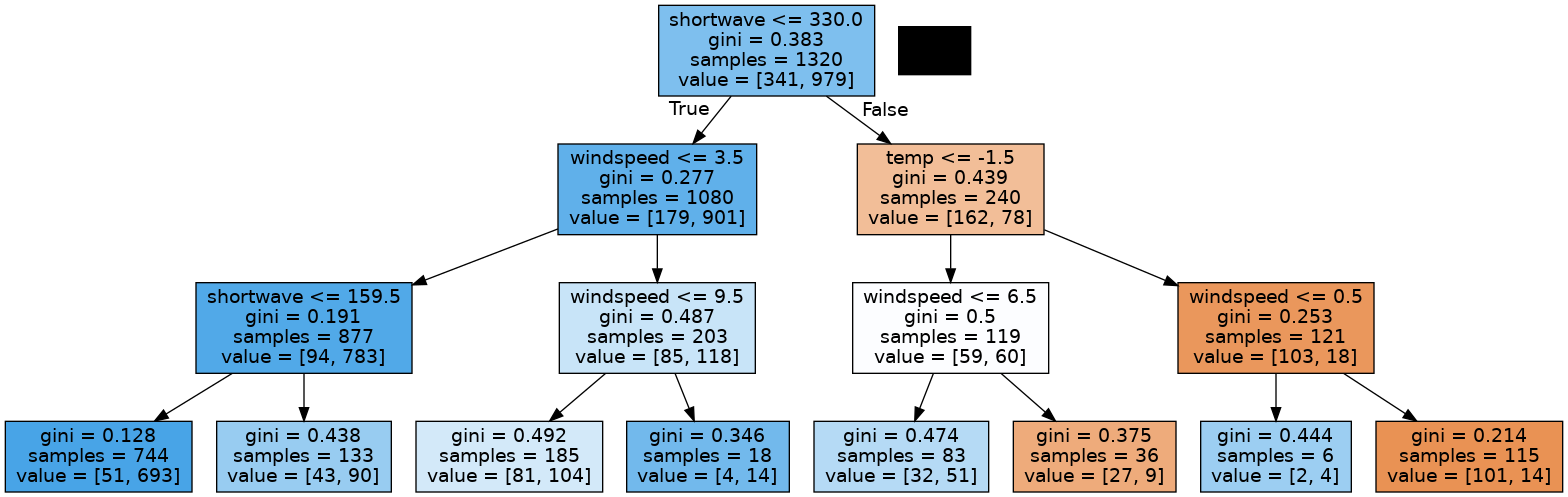

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
print('Accuracy on train data is %.2f' % (accuracy_score(y_train, y_pred_train)))

y_pred_test = clf.predict(X_test)
print('Accuracy on test data is %.2f' % (accuracy_score(y_test, y_pred_test)))

dot_data = tree.export_graphviz(clf, feature_names=X.columns, filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

## Now, Random Forest

In [16]:
number_model_runs = 1000 # for all random forest runs 

In [17]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=0)

parameters = {'n_estimators': [number_model_runs], 'max_depth':[3]} 
clf1 = GridSearchCV(ensemble.RandomForestClassifier(n_jobs=15), parameters) 

# trying to write it like this to get the n_jobs parameter to work 
# clf1  = ensemble.RandomForestClassifier(n_estimators=30, max_depth=3, n_jobs=4)

clf1.fit(X=X_train1,y=y_train1.values.ravel())
tree_model1 = clf1.best_estimator_ # only the GridSearchCV has the object "best_estimator_"

y_pred_train1 = tree_model1.predict(X_train1)
y_pred_test1 = tree_model1.predict(X_test1)
print('Accuracy on training data is %.2f' % (accuracy_score(y_train1, y_pred_train1)))
print('Accuracy on test data is %.2f' % (accuracy_score(y_test1, y_pred_test1)))
print(clf1.best_params_)

Accuracy on training data is 0.83
Accuracy on test data is 0.85
{'max_depth': 3, 'n_estimators': 1000}


In [18]:
estimatorAccuracy=[]
for curEstimator in range(number_model_runs):
    estimatorAccuracy.append([curEstimator,accuracy_score(y.values, tree_model1.estimators_[curEstimator].predict(X.values))])

estimatorAccuracy=pd.DataFrame(estimatorAccuracy,columns=['estimatorNumber','Accuracy'])
estimatorAccuracy.sort_values(inplace=True,by='Accuracy',ascending=False)

bestDecisionTree1= tree_model1.estimators_[estimatorAccuracy.head(1)['estimatorNumber'].values[0]]

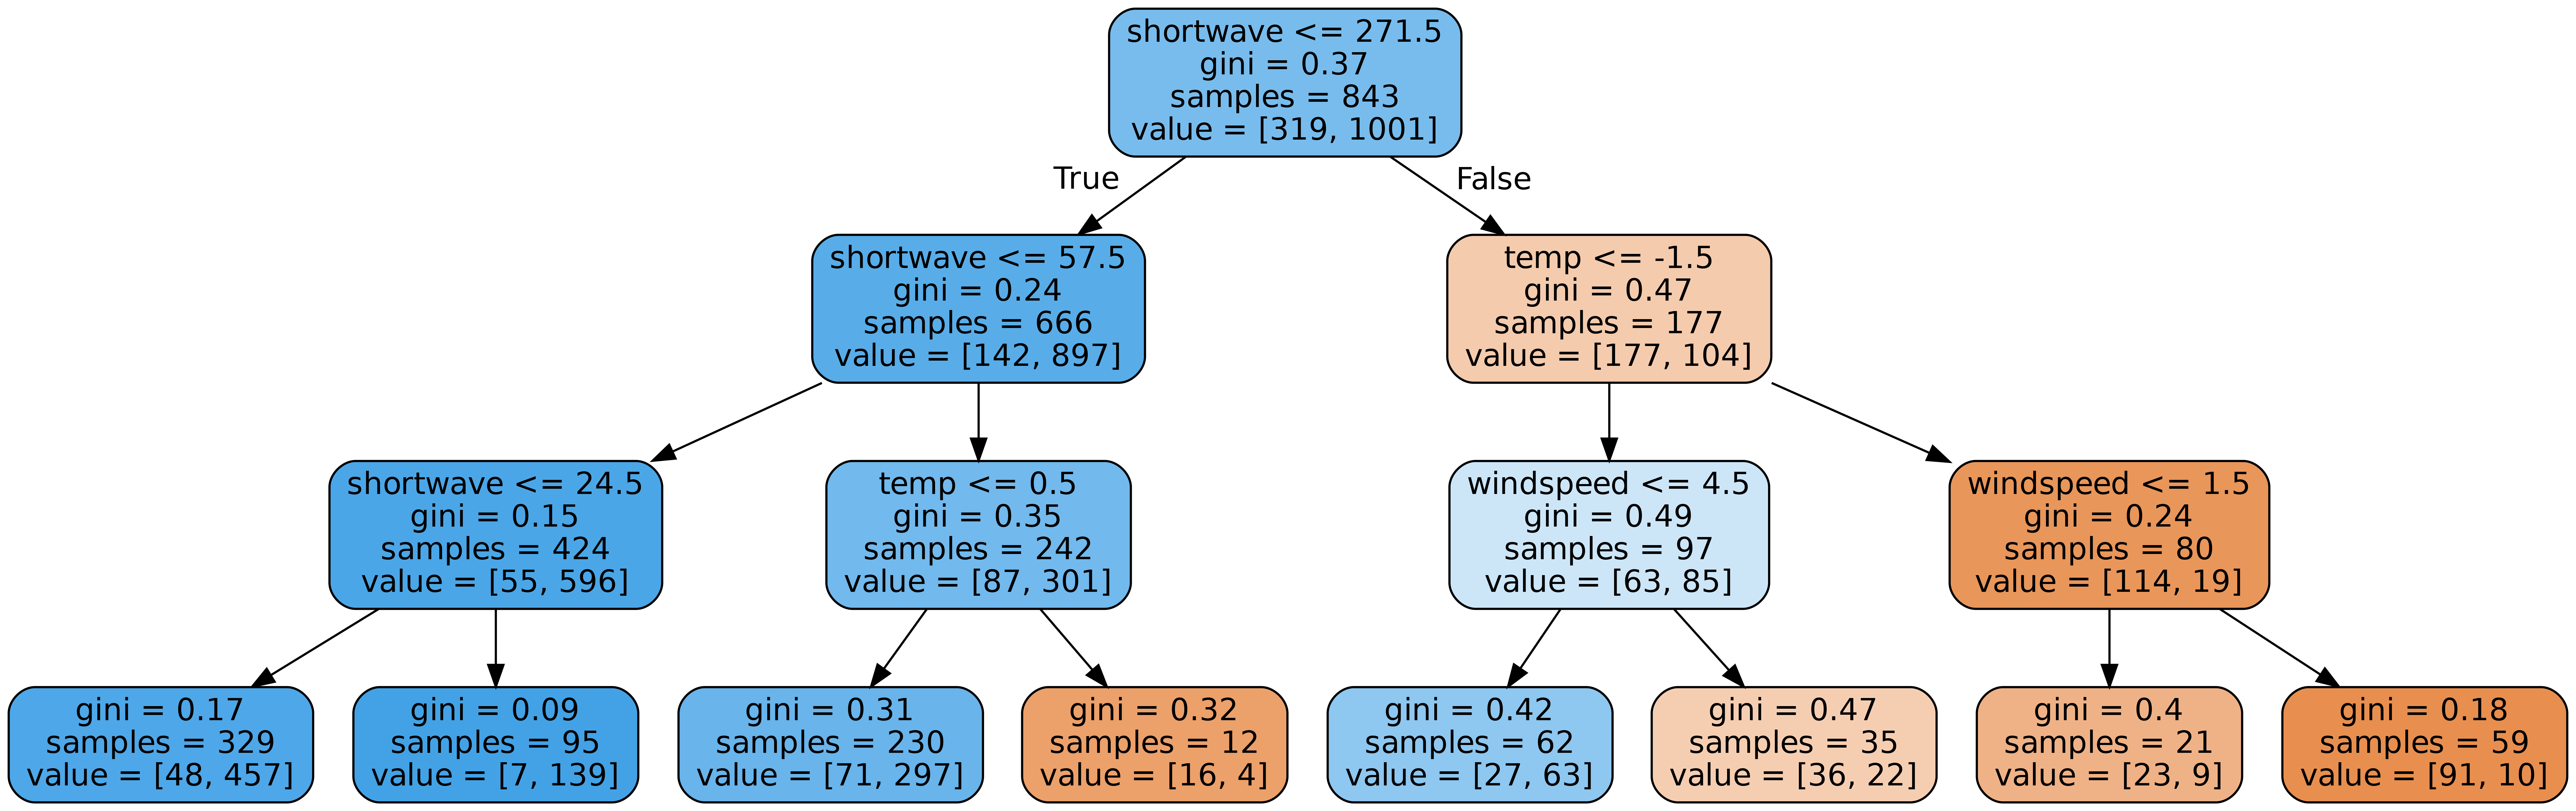

In [19]:
tree.export_graphviz(bestDecisionTree1, out_file='ensemble_tree1.dot', 
                feature_names = X.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree1.dot', '-o', 'ensemble_tree1.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree1.png')

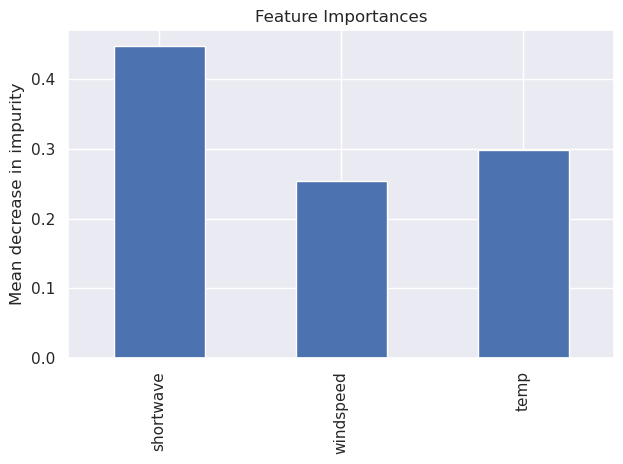

In [21]:
# Feature Importance 
importances1 = tree_model1.feature_importances_
std1 = np.std([tree_model1.feature_importances_ for tree in tree_model1.estimators_], axis=0)

forest_importances1 = pd.Series(importances1, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances1.plot.bar(yerr=std1, ax=ax)
ax.set_title("Feature Importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [22]:
# shortwave .45, windspeed .27, temperature .31

## Testing some things... 

In [20]:
tree_model1.predict([[200,0,-10]])

/home/lumbraca/mambaforge/envs/raster/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])

In [21]:
estimatorAccuracy

estimatorNumber  Accuracy
463              463  0.833939
772              772  0.833333
21                21  0.832121
924              924  0.832121
199              199  0.830909
..               ...       ...
912              912  0.763030
641              641  0.761818
996              996  0.761818
633              633  0.758788
295              295  0.755152

[1000 rows x 2 columns]

In [22]:
estimatorAccuracy.head()

estimatorNumber  Accuracy
463              463  0.833939
772              772  0.833333
21                21  0.832121
924              924  0.832121
199              199  0.830909

In [22]:
estimatorAccuracy['estimatorNumber'].values[1]

147

In [23]:
# bestDecisionTree1= tree_model1.estimators_[463] #first best
bestDecisionTree2= tree_model1.estimators_[772] #second best
bestDecisionTree3= tree_model1.estimators_[21] #third best ? find the number  
bestDecisionTree4= tree_model1.estimators_[924] #fourth best ? find the number 

Second best decision tree

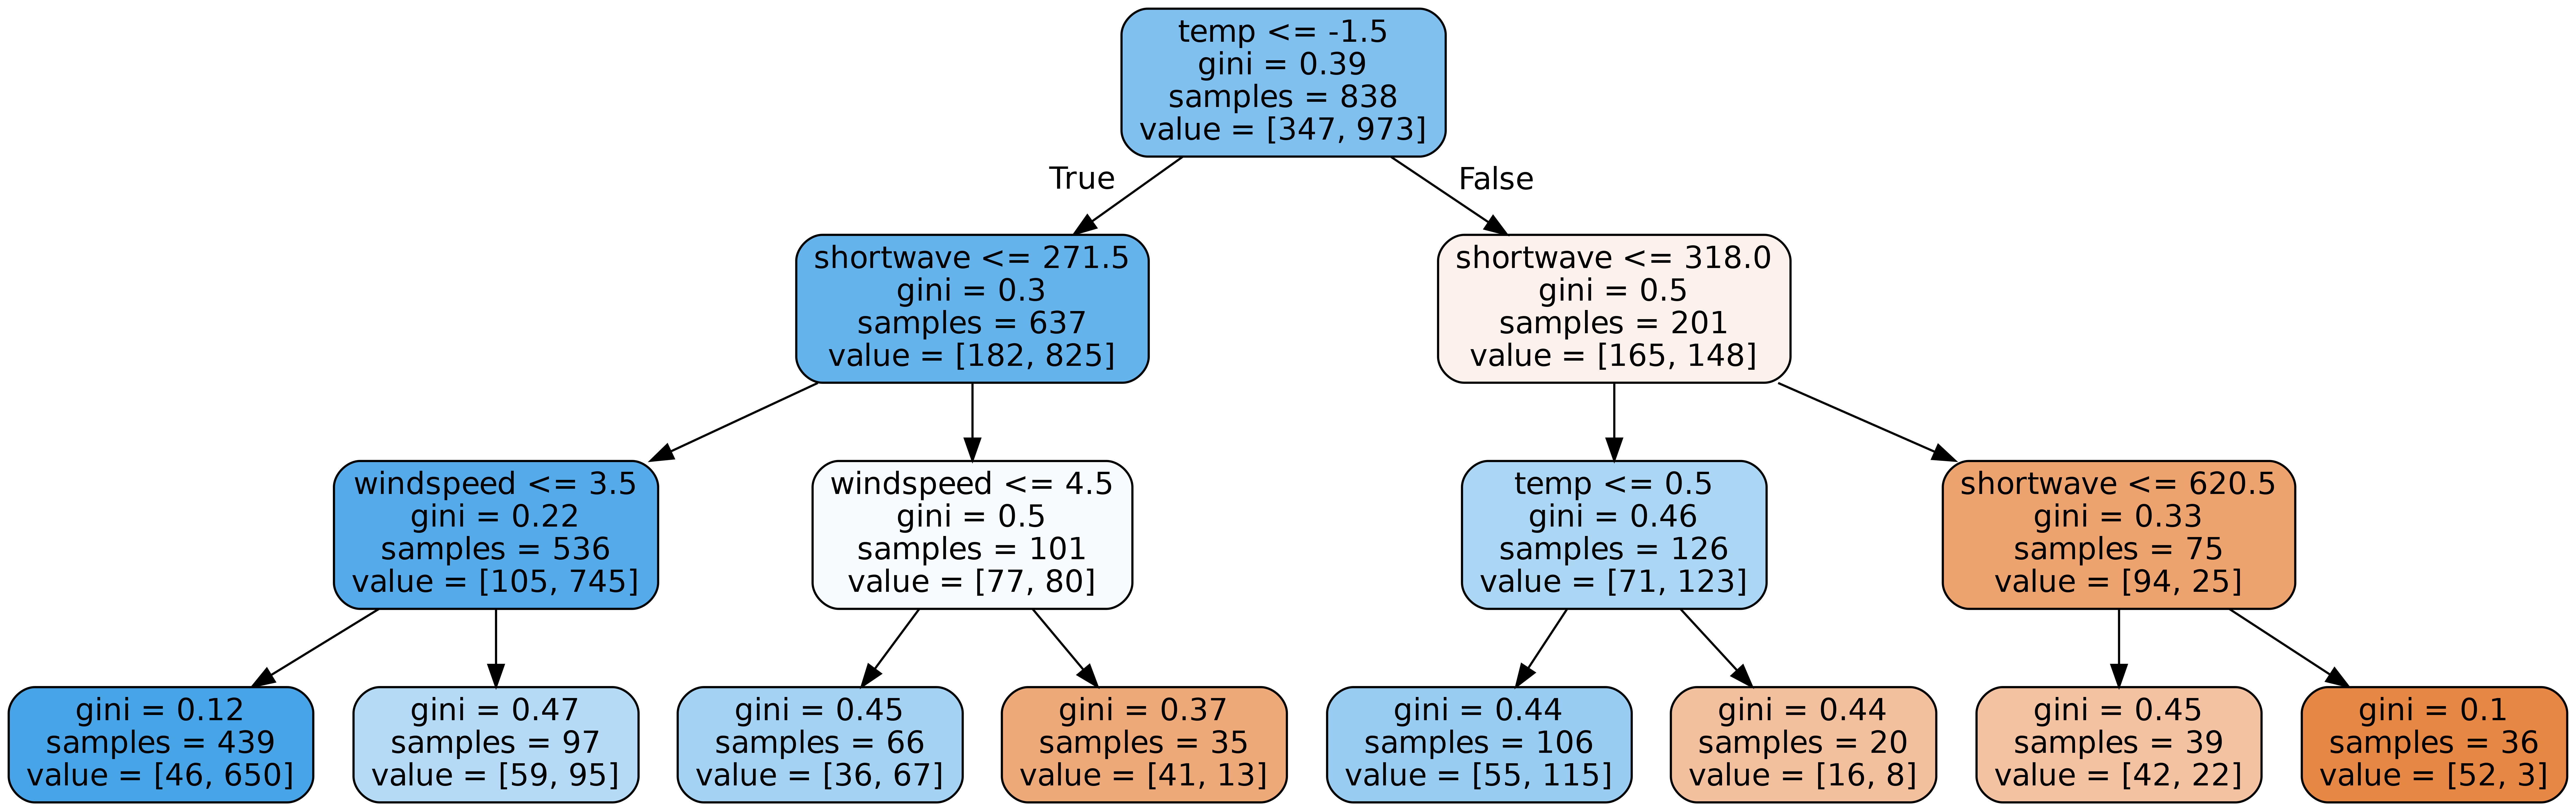

In [24]:
# bestDecisionTree2= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[1]]

tree.export_graphviz(bestDecisionTree2, out_file='ensemble_tree2.dot', 
                feature_names = X.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree2.dot', '-o', 'ensemble_tree2.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree2.png')

Third best decision tree

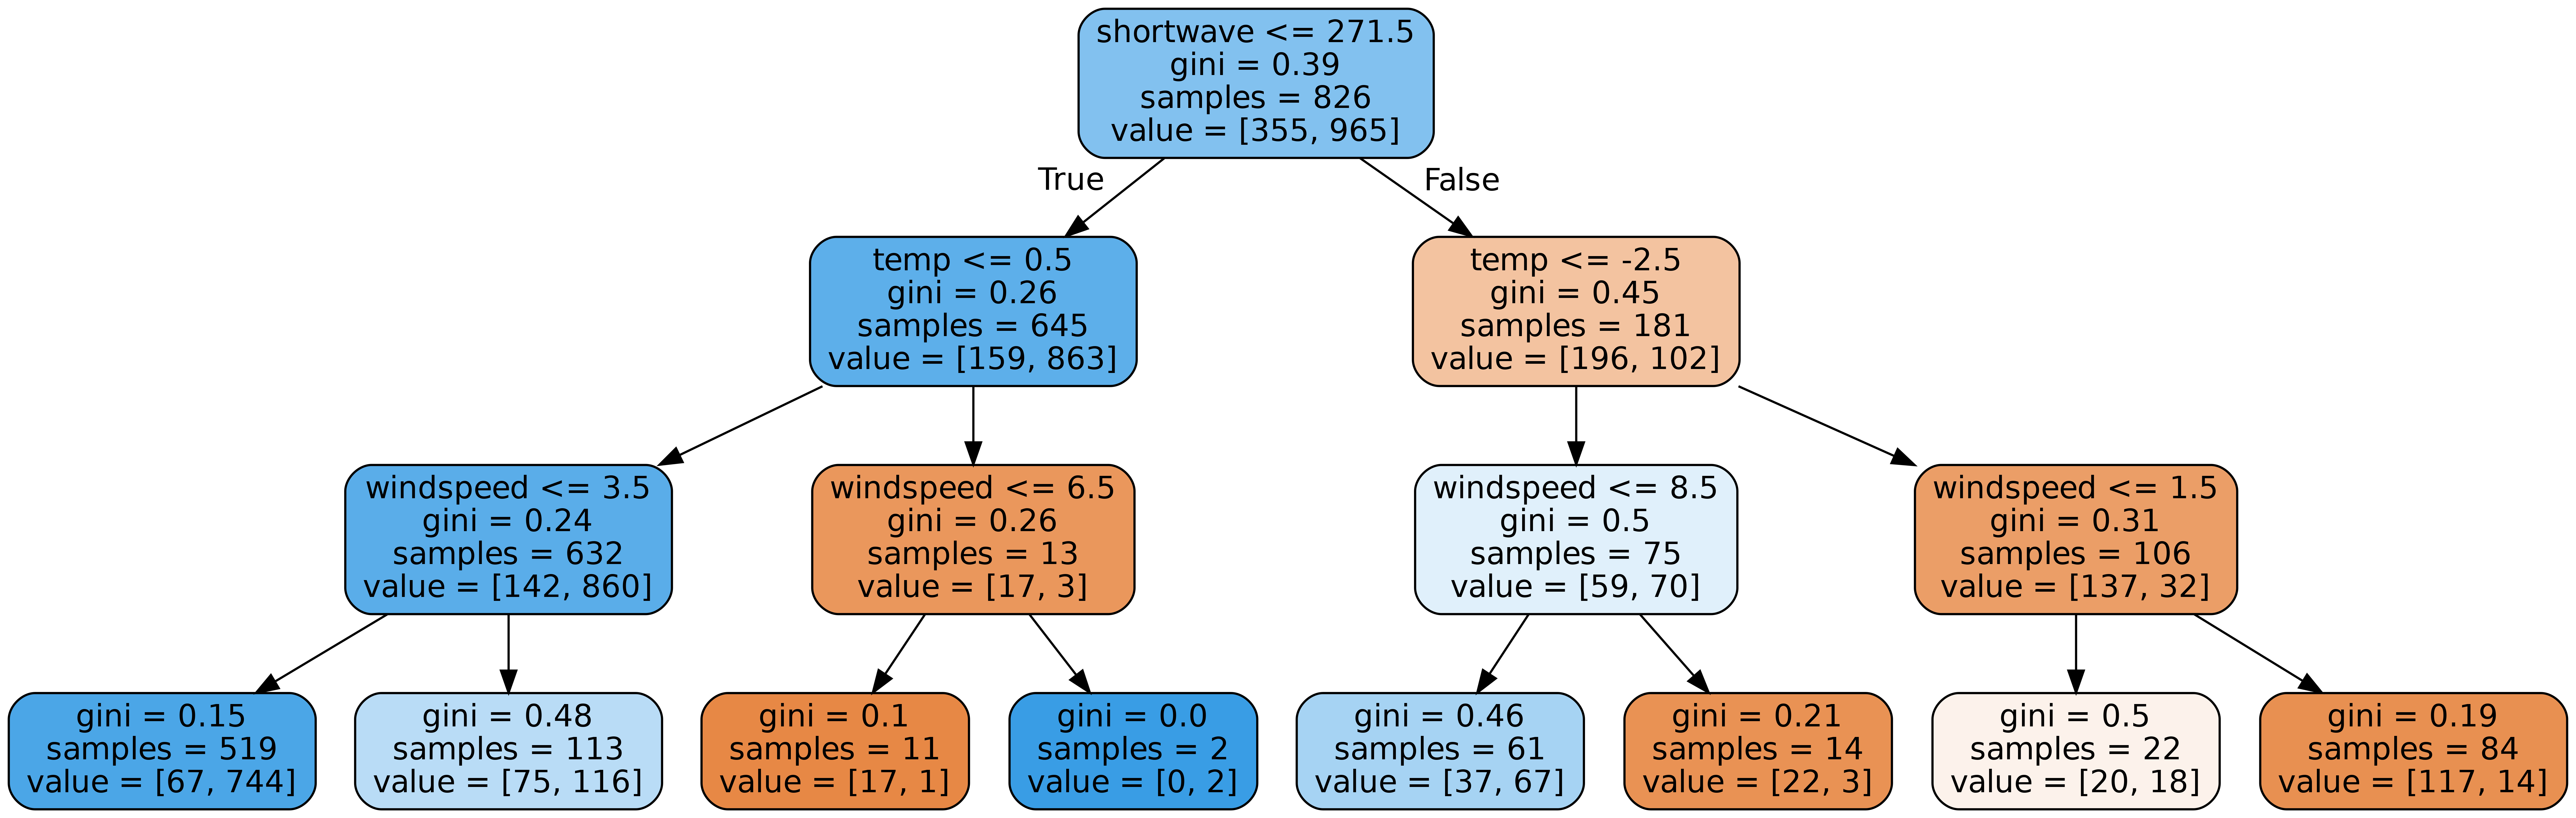

In [25]:
# bestDecisionTree2= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[1]]

tree.export_graphviz(bestDecisionTree3, out_file='ensemble_tree3.dot', 
                feature_names = X.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree3.dot', '-o', 'ensemble_tree3.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree3.png')

Fourth best decision tree...

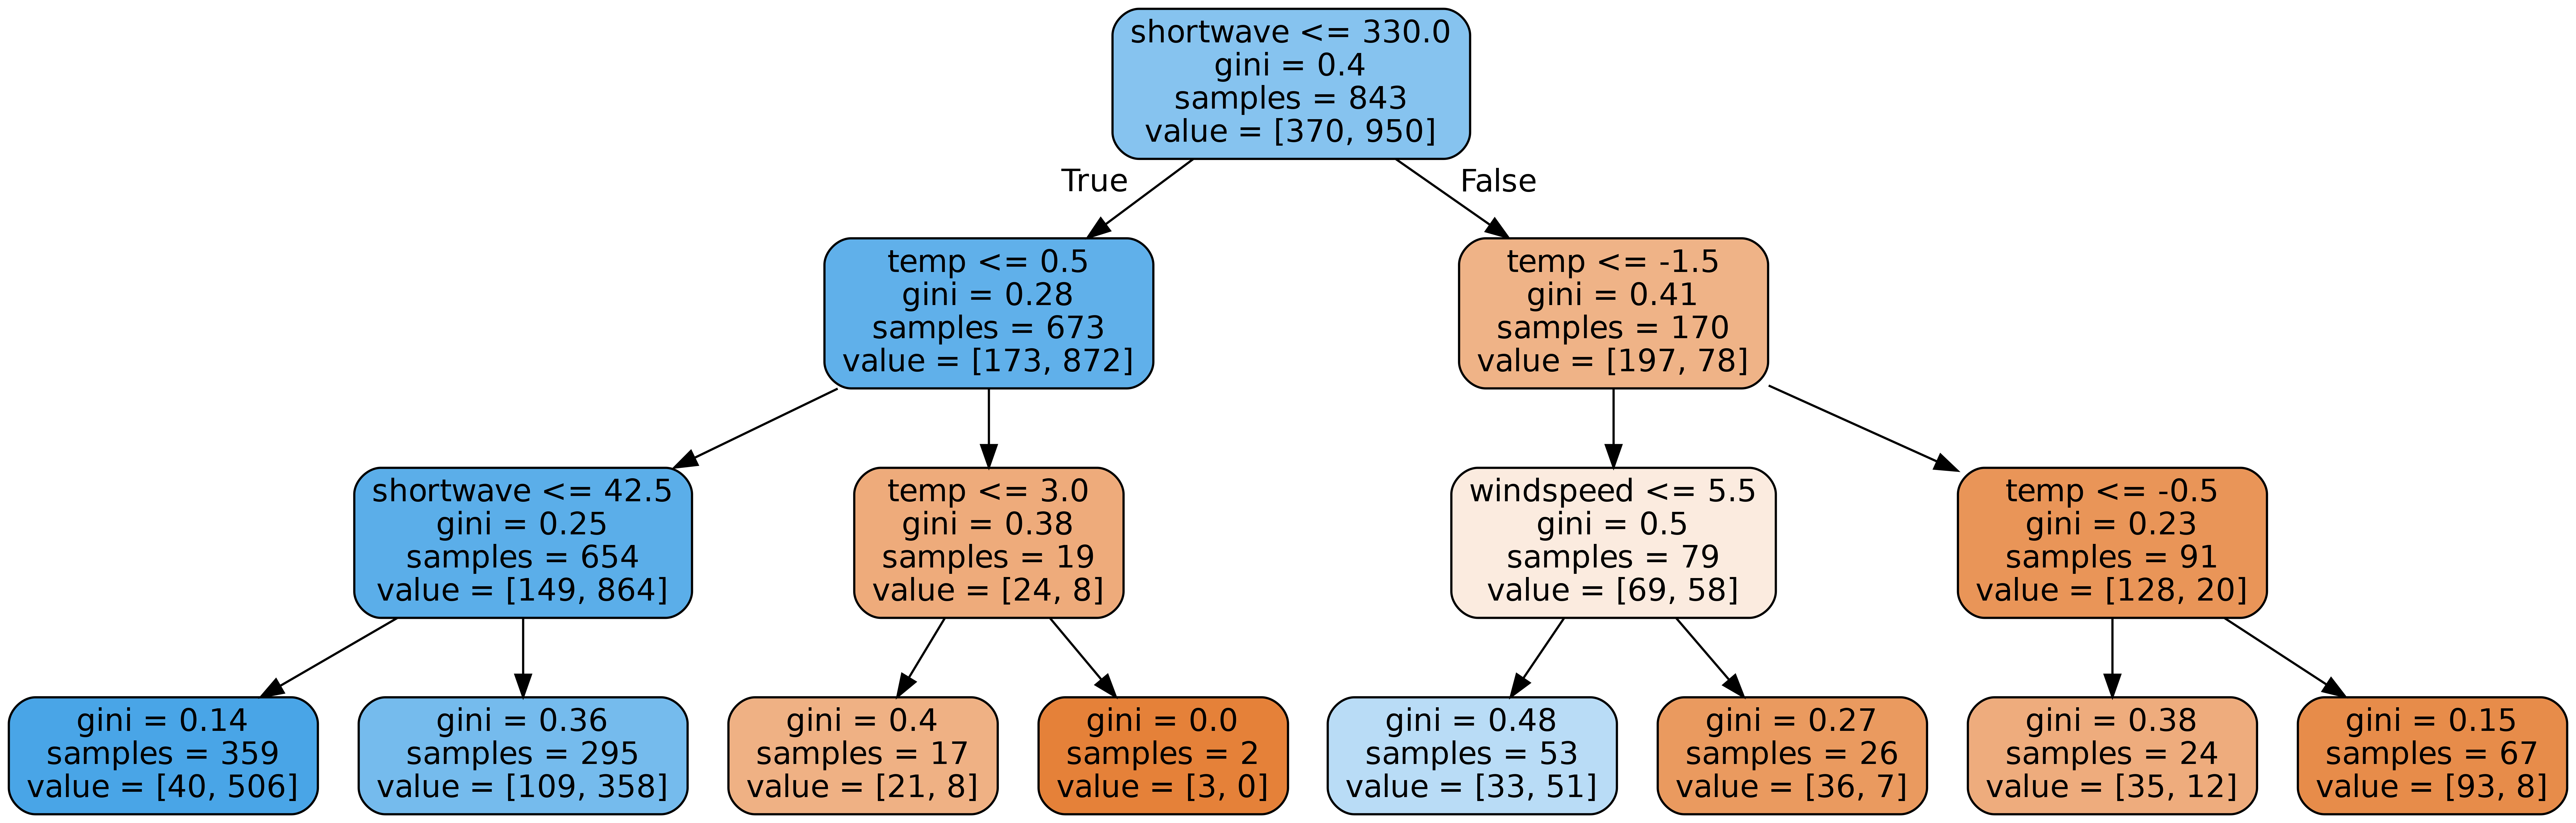

In [26]:
# bestDecisionTree2= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[1]]

tree.export_graphviz(bestDecisionTree4, out_file='ensemble_tree4.dot', 
                feature_names = X.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree4.dot', '-o', 'ensemble_tree4.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree4.png')

## Model Prediction Results

In [93]:
df_int_copy = df_int.copy(deep=True)
df_int_copy['model'] = np.nan
df_int_copy.head()

shortwave  windspeed  temp  CD  model
0          4          1    -3   1    NaN
1         29          1    -3   1    NaN
2        124          2    -2   1    NaN
3        102          2    -3   1    NaN
4        614          4    -3   1    NaN

In [94]:
print(len(df_int_copy))
print(len(df_int_sites))
print(len(X))

# so the length is not the issue, but since we dropped the na's, the index is not the same

1650
1650
1650


In [96]:
df_int_copy.reset_index(inplace=True)
df_int_sites.reset_index(inplace=True)
X.reset_index(inplace=True)

In [99]:
df_int_sites.drop(columns=['index'], inplace=True)

In [100]:
df_int_copy.drop(columns=['index'], inplace=True)
X.drop(columns=['index'], inplace=True)

In [103]:
## incase we rerun the above reset index twice my accident, another column named level_0 is created, so run this if we need
# df_int_copy.drop(columns=['level_0'], inplace=True)

In [104]:
# instead of test dataset, run the model on the full dataframe and save the result to a column in a new dataframe
# y_pred_test1 = tree_model1.predict(X_test1)
df_int_copy['model'] = pd.Series(tree_model1.predict(X))
df_int_copy

shortwave  windspeed  temp  CD  model
0             4          1    -3   1      1
1            29          1    -3   1      1
2           124          2    -2   1      1
3           102          2    -3   1      1
4           614          4    -3   1      0
...         ...        ...   ...  ..    ...
1645        400          0     2   1      0
1646        605          0     3   1      0
1647        854          1     4   0      0
1648        902          1     4   0      0
1649        948          1     4   0      0

[1650 rows x 5 columns]

### Now, try plotting to see if this worked

In [105]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr

import copy 
import pickle

from scipy import stats
from scipy.stats import norm

# interactive plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots # adding for subplots
import plotly.figure_factory as ff

In [106]:
nameallsitesA = 'A)  All Sites Together'
namesodankylaB = 'B)  Sodankylä, Finland'
namelaretC = 'C)  Davos Laret, Switzerland'
nameniwotD = 'D)  Niwot Ridge, Colorado, USA'

nametemperature = "air temperature (℃)"
namewindspeed = "wind speed (ms⁻¹)"
nameshortwave = "shortwave radiation (Wm⁻²)"

In [107]:
# define data 
threshold_line_color = 'grey'
# threshold_line_color = 'darkslategrey'
threshold_line_opacity = .2

# set plot constants 
group_labels = ['obs snow staying', 'obs snow unloading', 'model snow staying', 'model snow unloading']

# trying different colors for snow in the canopy for these plots only... we will see if it helps
colorsnow = '#7dcfd4' # slightly desaturated cyan
colorsnowunload = '#1F15D5' # bright, deep blue 
colorsnow2 = '#2acfd4' # a bit brighter cyan than colorsnow, we will try to see if this looks better on the plots
# unloadcolors = [colorsnow, colorsnowunload]
# colors = [colorsnow2, colorsnowunload, colorsnow2, colorsnowunload] # my colors 
colors = [colorsnow2, colorsnowunload, 'grey', 'black'] # my colors 

bintemp = 1
binwind = 1
binSW = 20

model_snowstay = df_int_copy.where(df_int_copy.model == 1) # 1 staying
model_snowunload = df_int_copy.where(df_int_copy.model == 0) # 0 unloading

df_snowstay = df_int_copy.where(df_int_copy.CD == 1) # 1 staying
df_snowunload = df_int_copy.where(df_int_copy.CD == 0) # 0 unloading

fig = make_subplots(rows=1, cols=3, shared_yaxes='columns', shared_xaxes='columns', 
                    # subplot_titles=("", nameallsitesA, "", "", namesodankylaB, "", "", namelaretC, "", "", nameniwotD), # centered
                    # subplot_titles=(namesod,"", "", namelaret, "", "", nameniwot, "", ""), # on the first one
                    horizontal_spacing = 0.04, vertical_spacing = 0.04)

# ROW ZERO NOW ADDING IT_____________________________________________________________________________________________________
# temp temperature 
x1 = df_snowstay.temp.dropna(how='all') 
x2 = df_snowunload.temp.dropna(how='all')

x3 = model_snowstay.temp.dropna(how='all') 
x4 = model_snowunload.temp.dropna(how='all') 

hist_data = [x1, x2, x3, x4]

fig1 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig1.select_traces():
    fig.add_trace(trace, row=1, col=1)
    fig.add_vline(x=-2.5, line_color=threshold_line_color, row=1, col=1, opacity=threshold_line_opacity)
    fig.add_vline(x=1.5, line_color=threshold_line_color, row=1, col=1, opacity=threshold_line_opacity)
    fig.add_vline(x=0.5, line_color=threshold_line_color, row=1, col=1, opacity=threshold_line_opacity)

# sod shortwave 
x1 = df_snowstay.shortwave.dropna(how='all') 
x2 = df_snowunload.shortwave.dropna(how='all')

x3 = model_snowstay.shortwave.dropna(how='all') 
x4 = model_snowunload.shortwave.dropna(how='all') 

hist_data = [x1, x2, x3, x4]

fig2 = ff.create_distplot(hist_data, group_labels, bin_size=binSW, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig2.select_traces():
    fig.add_trace(trace, row=1, col=2)
    fig.add_vline(x=258, line_color=threshold_line_color, row=1, col=2, opacity=threshold_line_opacity)
    fig.add_vline(x=57.5, line_color=threshold_line_color, row=1, col=2, opacity=threshold_line_opacity)


# sod windspeed 
x1 = df_snowstay.windspeed.dropna(how='all') 
x2 = df_snowunload.windspeed.dropna(how='all')

x3 = model_snowstay.windspeed.dropna(how='all') 
x4 = model_snowunload.windspeed.dropna(how='all') 

hist_data = [x1, x2, x3, x4]

fig2 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig2.select_traces():
    fig.add_trace(trace, row=1, col=3)
    fig.add_vline(x=3.5, line_color=threshold_line_color, row=1, col=3, opacity=threshold_line_opacity)
    fig.add_vline(x=5.5, line_color=threshold_line_color, row=1, col=3, opacity=threshold_line_opacity)

# # FIRST ROW_____________________________________________________________________________________________________
# # sod temperature 
# x1 = sod_df_snowstay.temp.dropna(how='all') 
# x2 = sod_df_snowunload.temp.dropna(how='all') 
# hist_data = [x1, x2]

# fig1 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
#                              show_hist=False, show_rug=False, curve_type='normal')


# for trace in fig1.select_traces():
#     fig.add_trace(trace, row=2, col=1)
#     fig.add_vline(x=-2.5, line_color=threshold_line_color, row=2, col=1, opacity=threshold_line_opacity)
#     fig.add_vline(x=1.5, line_color=threshold_line_color, row=2, col=1, opacity=threshold_line_opacity)
#     fig.add_vline(x=0.5, line_color=threshold_line_color, row=2, col=1, opacity=threshold_line_opacity)


# # sod shortwave 
# x1 = sod_df_snowstay.shortwave.dropna(how='all') 
# x2 = sod_df_snowunload.shortwave.dropna(how='all') 
# hist_data = [x1, x2]

# fig2 = ff.create_distplot(hist_data, group_labels, bin_size=binSW, colors=colors, 
#                              show_hist=False, show_rug=False, curve_type='normal')


# for trace in fig2.select_traces():
#     fig.add_trace(trace, row=2, col=2)
#     fig.add_vline(x=258, line_color=threshold_line_color, row=2, col=2, opacity=threshold_line_opacity)
#     fig.add_vline(x=57.5, line_color=threshold_line_color, row=2, col=2, opacity=threshold_line_opacity)


# # sod windspeed 
# x1 = sod_df_snowstay.windspeed.dropna(how='all') 
# x2 = sod_df_snowunload.windspeed.dropna(how='all') 
# hist_data = [x1, x2]

# fig2 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
#                              show_hist=False, show_rug=False, curve_type='normal')


# for trace in fig2.select_traces():
#     fig.add_trace(trace, row=2, col=3)
#     fig.add_vline(x=3.5, line_color=threshold_line_color, row=2, col=3, opacity=threshold_line_opacity)
#     fig.add_vline(x=5.5, line_color=threshold_line_color, row=2, col=3, opacity=threshold_line_opacity)


# # SECOND ROW_____________________________________________________________________________________________________
# # laret temperature 
# x1 = laret_df_snowstay.temp.dropna(how='all') 
# x2 = laret_df_snowunload.temp.dropna(how='all') 
# hist_data = [x1, x2]

# fig1 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
#                              show_hist=False, show_rug=False, curve_type='normal')


# for trace in fig1.select_traces():
#     fig.add_trace(trace, row=3, col=1)
#     fig.add_vline(x=-2.5, line_color=threshold_line_color, row=3, col=1, opacity=threshold_line_opacity)
#     fig.add_vline(x=1.5, line_color=threshold_line_color, row=3, col=1, opacity=threshold_line_opacity)
#     fig.add_vline(x=0.5, line_color=threshold_line_color, row=3, col=1, opacity=threshold_line_opacity)

# # laret shortwave 
# x1 = laret_df_snowstay.shortwave.dropna(how='all') 
# x2 = laret_df_snowunload.shortwave.dropna(how='all') 
# hist_data = [x1, x2]

# fig2 = ff.create_distplot(hist_data, group_labels, bin_size=binSW, colors=colors, 
#                              show_hist=False, show_rug=False, curve_type='normal')


# for trace in fig2.select_traces():
#     fig.add_trace(trace, row=3, col=2)
#     fig.add_vline(x=258, line_color=threshold_line_color, row=3, col=2, opacity=threshold_line_opacity)
#     fig.add_vline(x=57.5, line_color=threshold_line_color, row=3, col=2, opacity=threshold_line_opacity)


# # laret windspeed 
# x1 = laret_df_snowstay.windspeed.dropna(how='all') 
# x2 = laret_df_snowunload.windspeed.dropna(how='all') 
# hist_data = [x1, x2]

# fig2 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
#                              show_hist=False, show_rug=False, curve_type='normal')


# for trace in fig2.select_traces():
#     fig.add_trace(trace, row=3, col=3)
#     fig.add_vline(x=3.5, line_color=threshold_line_color, row=3, col=3, opacity=threshold_line_opacity)
#     fig.add_vline(x=5.5, line_color=threshold_line_color, row=3, col=3, opacity=threshold_line_opacity)

# # THIRD ROW_____________________________________________________________________________________________________
# # niwot temperature 
# x1 = niwot_df_snowstay.temp.dropna(how='all') 
# x2 = niwot_df_snowunload.temp.dropna(how='all') 
# hist_data = [x1, x2]

# fig1 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
#                              show_hist=False, show_rug=False, curve_type='normal')


# for trace in fig1.select_traces():
#     fig.add_trace(trace, row=4, col=1)
#     fig.add_vline(x=-2.5, line_color=threshold_line_color, row=4, col=1, opacity=threshold_line_opacity)
#     fig.add_vline(x=1.5, line_color=threshold_line_color, row=4, col=1, opacity=threshold_line_opacity)
#     fig.add_vline(x=0.5, line_color=threshold_line_color, row=4, col=1, opacity=threshold_line_opacity)
    

# # niwot shortwave 
# x1 = niwot_df_snowstay.shortwave.dropna(how='all') 
# x2 = niwot_df_snowunload.shortwave.dropna(how='all') 
# hist_data = [x1, x2]

# fig2 = ff.create_distplot(hist_data, group_labels, bin_size=binSW, colors=colors, 
#                              show_hist=False, show_rug=False, curve_type='normal')


# for trace in fig2.select_traces():
#     fig.add_trace(trace, row=4, col=2)
#     fig.add_vline(x=258, line_color=threshold_line_color, row=4, col=2, opacity=threshold_line_opacity)
#     fig.add_vline(x=57.5, line_color=threshold_line_color, row=4, col=2, opacity=threshold_line_opacity)


# # niwot windspeed 
# x1 = niwot_df_snowstay.windspeed.dropna(how='all') 
# x2 = niwot_df_snowunload.windspeed.dropna(how='all') 
# hist_data = [x1, x2]

# fig2 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors,
#                              show_hist=False, show_rug=False, curve_type='normal')


# for trace in fig2.select_traces():
#     fig.add_trace(trace, row=4, col=3)
#     # fig.add_vline(x=np.mean(x1), line_color=colorsnow, line_dash='dash', row=4, col=3) # the code if we want to plot the mean PDF lines
#     # fig.add_vline(x=np.mean(x2), line_color=colorsnowunload, line_dash='dash', row=4, col=3)
#     fig.add_vline(x=3.5, line_color=threshold_line_color, row=4, col=3, opacity=threshold_line_opacity)
#     fig.add_vline(x=5.5, line_color=threshold_line_color, row=4, col=3, opacity=threshold_line_opacity)
#     # fig.add_trace(trace, row=4, col=3) # was trying to put this here to reorder.., but it did not do anything 



# update legends layouts and labels 
fig.update_layout(title='Observations vs. Random Forest Model for all data', width=1200, height=400, showlegend=True)

fig.update_yaxes(title_text='probability density', row=1, col=1) # consider trying to make this a text on the side of the page instead to center it

fig.update_xaxes(title_text=nametemperature, row=4, col=1)
fig.update_xaxes(title_text=nameshortwave, row=4, col=2)
fig.update_xaxes(title_text=namewindspeed, row=4, col=3)

# fig.add_annotation(x=2, y=.1, text='texting', )

fig.show()

# Trying putting it all together for the sites 

In [108]:
df_int_sites['model'] = df_int_copy['model'].copy(deep=True)
df_int_sites

shortwave  windspeed      temp   CD  Classification   site  model
0       4.930000   1.180000 -3.495000  1.0    Snow Staying  niwot      1
1      29.430000   1.735000 -3.325000  1.0    Snow Staying  niwot      1
2     124.500000   2.080000 -2.430000  1.0    Snow Staying  niwot      1
3     102.040000   2.745000 -3.250000  1.0    Snow Staying  niwot      1
4     614.380000   4.595000 -3.350000  1.0    Snow Staying  niwot      0
...          ...        ...       ...  ...             ...    ...    ...
1645  400.306250   0.770125  2.143021  1.0    Snow Staying  laret      0
1646  605.846250   0.973554  3.865325  1.0    Snow Staying  laret      0
1647  854.292500   1.648042  4.049008  0.0  Snow Unloading  laret      0
1648  902.823333   1.427383  4.768171  0.0  Snow Unloading  laret      0
1649  948.237500   1.719404  4.717921  0.0  Snow Unloading  laret      0

[1650 rows x 7 columns]

Might want to be careful with this and come back, because the model for laret is NAN? strange

In [39]:
# define data 
threshold_line_color = 'grey'
# threshold_line_color = 'darkslategrey'
threshold_line_opacity = .2

# set plot constants 
group_labels = ['obs snow staying', 'obs snow unloading', 'model snow staying', 'model snow unloading']

# trying different colors for snow in the canopy for these plots only... we will see if it helps
colorsnow = '#7dcfd4' # slightly desaturated cyan
colorsnowunload = '#1F15D5' # bright, deep blue 
colorsnow2 = '#2acfd4' # a bit brighter cyan than colorsnow, we will try to see if this looks better on the plots
# unloadcolors = [colorsnow, colorsnowunload]
# colors = [colorsnow2, colorsnowunload, colorsnow2, colorsnowunload] # my colors 
colors = [colorsnow2, colorsnowunload, 'darkslategrey', 'black'] # my colors 

bintemp = 1
binwind = 1
binSW = 20

model_snowstay = df_int_sites.where(df_int_sites.model == 1) # 1 staying
model_snowunload = df_int_sites.where(df_int_sites.model == 0) # 0 unloading

df_snowstay = df_int_sites.where(df_int_sites.CD == 1) # 1 staying
df_snowunload = df_int_sites.where(df_int_sites.CD == 0) # 0 unloading

fig = make_subplots(rows=4, cols=3, shared_yaxes='columns', shared_xaxes='columns', 
                    subplot_titles=("", nameallsitesA, "", "", namesodankylaB, "", "", namelaretC, "", "", nameniwotD), # centered
                    # subplot_titles=(namesod,"", "", namelaret, "", "", nameniwot, "", ""), # on the first one
                    horizontal_spacing = 0.04, vertical_spacing = 0.04)

# ROW ZERO NOW ADDING IT_____________________________________________________________________________________________________
# all sites temperature 
x1 = df_snowstay.temp.dropna(how='all') 
x2 = df_snowunload.temp.dropna(how='all')

x3 = model_snowstay.temp.dropna(how='all') 
x4 = model_snowunload.temp.dropna(how='all') 
hist_data = [x1, x2, x3, x4]

fig1 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig1.select_traces():
    fig.add_trace(trace, row=1, col=1)
    fig.add_vline(x=-2.5, line_color=threshold_line_color, row=1, col=1, opacity=threshold_line_opacity)
    fig.add_vline(x=1.5, line_color=threshold_line_color, row=1, col=1, opacity=threshold_line_opacity)
    fig.add_vline(x=0.5, line_color=threshold_line_color, row=1, col=1, opacity=threshold_line_opacity)

# all sites shortwave 
x1 = df_snowstay.shortwave.dropna(how='all') 
x2 = df_snowunload.shortwave.dropna(how='all')

x3 = model_snowstay.shortwave.dropna(how='all') 
x4 = model_snowunload.shortwave.dropna(how='all') 
hist_data = [x1, x2, x3, x4]

fig2 = ff.create_distplot(hist_data, group_labels, bin_size=binSW, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig2.select_traces():
    fig.add_trace(trace, row=1, col=2)
    fig.add_vline(x=258, line_color=threshold_line_color, row=1, col=2, opacity=threshold_line_opacity)
    fig.add_vline(x=57.5, line_color=threshold_line_color, row=1, col=2, opacity=threshold_line_opacity)


# all sites windspeed 
x1 = df_snowstay.windspeed.dropna(how='all') 
x2 = df_snowunload.windspeed.dropna(how='all')

x3 = model_snowstay.windspeed.dropna(how='all') 
x4 = model_snowunload.windspeed.dropna(how='all') 
hist_data = [x1, x2, x3, x4]

fig2 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig2.select_traces():
    fig.add_trace(trace, row=1, col=3)
    fig.add_vline(x=3.5, line_color=threshold_line_color, row=1, col=3, opacity=threshold_line_opacity)
    fig.add_vline(x=5.5, line_color=threshold_line_color, row=1, col=3, opacity=threshold_line_opacity)

# FIRST ROW_____________________________________________________________________________________________________
# sod temperature 

x1 = df_snowstay.temp.where(df_snowstay.site == 'sod').dropna(how='all')
x2 = df_snowunload.temp.where(df_snowunload.site == 'sod').dropna(how='all')
x3 = model_snowstay.temp.where(model_snowstay.site == 'sod').dropna(how='all')
x4 = model_snowunload.temp.where(model_snowunload.site == 'sod').dropna(how='all')
hist_data = [x1, x2, x3, x4]


fig1 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig1.select_traces():
    fig.add_trace(trace, row=2, col=1)
    fig.add_vline(x=-2.5, line_color=threshold_line_color, row=2, col=1, opacity=threshold_line_opacity)
    fig.add_vline(x=1.5, line_color=threshold_line_color, row=2, col=1, opacity=threshold_line_opacity)
    fig.add_vline(x=0.5, line_color=threshold_line_color, row=2, col=1, opacity=threshold_line_opacity)


# sod shortwave 
x1 = df_snowstay.shortwave.where(df_snowstay.site == 'sod').dropna(how='all')
x2 = df_snowunload.shortwave.where(df_snowunload.site == 'sod').dropna(how='all')
x3 = model_snowstay.shortwave.where(model_snowstay.site == 'sod').dropna(how='all')
x4 = model_snowunload.shortwave.where(model_snowunload.site == 'sod').dropna(how='all')
hist_data = [x1, x2, x3, x4]


fig2 = ff.create_distplot(hist_data, group_labels, bin_size=binSW, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig2.select_traces():
    fig.add_trace(trace, row=2, col=2)
    fig.add_vline(x=258, line_color=threshold_line_color, row=2, col=2, opacity=threshold_line_opacity)
    fig.add_vline(x=57.5, line_color=threshold_line_color, row=2, col=2, opacity=threshold_line_opacity)


# sod windspeed 
x1 = df_snowstay.windspeed.where(df_snowstay.site == 'sod').dropna(how='all')
x2 = df_snowunload.windspeed.where(df_snowunload.site == 'sod').dropna(how='all')
x3 = model_snowstay.windspeed.where(model_snowstay.site == 'sod').dropna(how='all')
x4 = model_snowunload.windspeed.where(model_snowunload.site == 'sod').dropna(how='all')
hist_data = [x1, x2, x3, x4]

fig2 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig2.select_traces():
    fig.add_trace(trace, row=2, col=3)
    fig.add_vline(x=3.5, line_color=threshold_line_color, row=2, col=3, opacity=threshold_line_opacity)
    fig.add_vline(x=5.5, line_color=threshold_line_color, row=2, col=3, opacity=threshold_line_opacity)


# SECOND ROW_____________________________________________________________________________________________________
# laret temperature 
x1 = df_snowstay.temp.where(df_snowstay.site == 'laret').dropna(how='all')
x2 = df_snowunload.temp.where(df_snowunload.site == 'laret').dropna(how='all')
x3 = model_snowstay.temp.where(model_snowstay.site == 'laret').dropna(how='all')
x4 = model_snowunload.temp.where(model_snowunload.site == 'laret').dropna(how='all')
hist_data = [x1, x2, x3, x4]

fig1 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig1.select_traces():
    fig.add_trace(trace, row=3, col=1)
    fig.add_vline(x=-2.5, line_color=threshold_line_color, row=3, col=1, opacity=threshold_line_opacity)
    fig.add_vline(x=1.5, line_color=threshold_line_color, row=3, col=1, opacity=threshold_line_opacity)
    fig.add_vline(x=0.5, line_color=threshold_line_color, row=3, col=1, opacity=threshold_line_opacity)

# laret shortwave 
x1 = df_snowstay.shortwave.where(df_snowstay.site == 'laret').dropna(how='all')
x2 = df_snowunload.shortwave.where(df_snowunload.site == 'laret').dropna(how='all')
x3 = model_snowstay.shortwave.where(model_snowstay.site == 'laret').dropna(how='all')
x4 = model_snowunload.shortwave.where(model_snowunload.site == 'laret').dropna(how='all')
hist_data = [x1, x2, x3, x4]

fig2 = ff.create_distplot(hist_data, group_labels, bin_size=binSW, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig2.select_traces():
    fig.add_trace(trace, row=3, col=2)
    fig.add_vline(x=258, line_color=threshold_line_color, row=3, col=2, opacity=threshold_line_opacity)
    fig.add_vline(x=57.5, line_color=threshold_line_color, row=3, col=2, opacity=threshold_line_opacity)


# laret windspeed 
x1 = df_snowstay.windspeed.where(df_snowstay.site == 'laret').dropna(how='all')
x2 = df_snowunload.windspeed.where(df_snowunload.site == 'laret').dropna(how='all')
x3 = model_snowstay.windspeed.where(model_snowstay.site == 'laret').dropna(how='all')
x4 = model_snowunload.windspeed.where(model_snowunload.site == 'laret').dropna(how='all')
hist_data = [x1, x2, x3, x4]

fig2 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig2.select_traces():
    fig.add_trace(trace, row=3, col=3)
    fig.add_vline(x=3.5, line_color=threshold_line_color, row=3, col=3, opacity=threshold_line_opacity)
    fig.add_vline(x=5.5, line_color=threshold_line_color, row=3, col=3, opacity=threshold_line_opacity)

# THIRD ROW_____________________________________________________________________________________________________
# niwot temperature 
x1 = df_snowstay.temp.where(df_snowstay.site == 'niwot').dropna(how='all')
x2 = df_snowunload.temp.where(df_snowunload.site == 'niwot').dropna(how='all')
x3 = model_snowstay.temp.where(model_snowstay.site == 'niwot').dropna(how='all')
x4 = model_snowunload.temp.where(model_snowunload.site == 'niwot').dropna(how='all')
hist_data = [x1, x2, x3, x4]

fig1 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig1.select_traces():
    fig.add_trace(trace, row=4, col=1)
    fig.add_vline(x=-2.5, line_color=threshold_line_color, row=4, col=1, opacity=threshold_line_opacity)
    fig.add_vline(x=1.5, line_color=threshold_line_color, row=4, col=1, opacity=threshold_line_opacity)
    fig.add_vline(x=0.5, line_color=threshold_line_color, row=4, col=1, opacity=threshold_line_opacity)
    

# niwot shortwave 
x1 = df_snowstay.shortwave.where(df_snowstay.site == 'niwot').dropna(how='all')
x2 = df_snowunload.shortwave.where(df_snowunload.site == 'niwot').dropna(how='all')
x3 = model_snowstay.shortwave.where(model_snowstay.site == 'niwot').dropna(how='all')
x4 = model_snowunload.shortwave.where(model_snowunload.site == 'niwot').dropna(how='all')
hist_data = [x1, x2, x3, x4]

fig2 = ff.create_distplot(hist_data, group_labels, bin_size=binSW, colors=colors, 
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig2.select_traces():
    fig.add_trace(trace, row=4, col=2)
    fig.add_vline(x=258, line_color=threshold_line_color, row=4, col=2, opacity=threshold_line_opacity)
    fig.add_vline(x=57.5, line_color=threshold_line_color, row=4, col=2, opacity=threshold_line_opacity)


# niwot windspeed 
x1 = df_snowstay.windspeed.where(df_snowstay.site == 'niwot').dropna(how='all')
x2 = df_snowunload.windspeed.where(df_snowunload.site == 'niwot').dropna(how='all')
x3 = model_snowstay.windspeed.where(model_snowstay.site == 'niwot').dropna(how='all')
x4 = model_snowunload.windspeed.where(model_snowunload.site == 'niwot').dropna(how='all')
hist_data = [x1, x2, x3, x4]

fig2 = ff.create_distplot(hist_data, group_labels, bin_size=bintemp, colors=colors,
                             show_hist=False, show_rug=False, curve_type='normal')


for trace in fig2.select_traces():
    fig.add_trace(trace, row=4, col=3)
    # fig.add_vline(x=np.mean(x1), line_color=colorsnow, line_dash='dash', row=4, col=3) # the code if we want to plot the mean PDF lines
    # fig.add_vline(x=np.mean(x2), line_color=colorsnowunload, line_dash='dash', row=4, col=3)
    fig.add_vline(x=3.5, line_color=threshold_line_color, row=4, col=3, opacity=threshold_line_opacity)
    fig.add_vline(x=5.5, line_color=threshold_line_color, row=4, col=3, opacity=threshold_line_opacity)
    # fig.add_trace(trace, row=4, col=3) # was trying to put this here to reorder.., but it did not do anything 



# update legends layouts and labels 
fig.update_layout(title='Observations vs. Random Forest Model for all data', width=1200, height=1400, showlegend=False)

fig.update_yaxes(title_text='probability density', row=3, col=1) # consider trying to make this a text on the side of the page instead to center it

fig.update_xaxes(title_text=nametemperature, row=4, col=1)
fig.update_xaxes(title_text=nameshortwave, row=4, col=2)
fig.update_xaxes(title_text=namewindspeed, row=4, col=3)

# fig.add_annotation(x=2, y=.1, text='texting', )

fig.show()

## Lets move all the plotting to the manuscript figures script 
so, we need to save the model to use it later 

In [41]:
tree_model1

RandomForestClassifier(max_depth=3, n_estimators=1000, n_jobs=15)

In [42]:
# first, save the entire random forest model
filename = 'rfmodel_int_20_1000.pkl' # random forest model with integers, trained on 20% of the data, 1000 trees
pickle.dump(tree_model1, open(filename, 'wb')) # wb, writing 

# loaded_model = pickle.load(open(filename, 'rb')) # rb, reading 
# result = loaded_model.score(X_test, y_test)
# print(result)

Now, also save the simple dataframe we used to plot above for later

In [ ]:
# df_int_sites # this is the dataframe with all the met data saved (as floats) with the CD column, sites, and model column added (int model)
df_int_sites.to_csv('rfmodel_int_20_1000_results_with_metdata.csv') 